# One dimension convolutional networks

In this notebook we train several convolutional networks and evaluate their accuracy for the stated problem (classification of EEG signals).

In [1]:
%cd ..

/home/quentin/Documents/Courses/Deep learning/Projects/project1/src


In [2]:
import numpy as np

from utils.loading import load_data, save_obj, load_obj

import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils.cross_validation import early_stopping
from utils.cross_validation import cross_validation

from utils.visualization import plot_history

In [23]:
x_train, y_train = load_data(one_khz=False)
x_test, y_test = load_data(train=False, one_khz=False)

x_train_one_khz, y_train_one_khz = load_data(one_khz=True)
x_test_one_khz, y_test_one_khz = load_data(train=False, one_khz=True)

## Basic convolutional network with 1 convolution

We use this basic convolutional network with only one convolution to test hyper-parameters such as the learning rate or the type of optimizer. We evaluate the performances with cross validation and will further improve this model adding more layers or tricks such as dropout and batch normalization.

In [12]:
from conv_models import ConvNet1

### Training with the 100Hz sampled data

#### Cross validation over the learning rate

We first have to tune the learning rate with the `cross_validation` function.

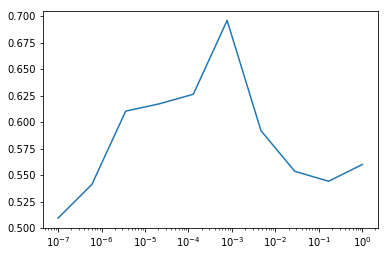

In [13]:
lr_list = np.logspace(-7, 0, 10)

acc_list = []
std_list = []

for lr in lr_list:
    acc, std = cross_validation(ConvNet1, x_train, y_train, epochs=1000, lr=lr)
    acc_list.append(acc)
    std_list.append(std)
    
plt.semilogx(lr_list, acc_list)

In [14]:
# /!\ Do not run unless you want to override it !
save_obj((acc_list, std_list), 'cross_val_lr')

In [41]:
acc_list, std_list = load_obj('cross_val_lr')
lr_tuned = lr_list[np.argmax(acc_list)]
print('The tuned learning rate is {}.'.format(round(lr_tuned, 6)))

The tuned learning rate is 0.000774.


#### Training the model

In [47]:
acc_list = cross_validation(lambda: ConvNet1(one_khz=False), x_train, y_train, raw=True,
                            epochs=100, lr=lr_tuned, batch_size=16,
                            standardize=True, noise=False, crop=False)
acc = round(100*np.mean(acc_list), 4)
std = round(100*np.std(acc_list), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 77.8621+/-4.4024%


### Training with the 1kHZ sampled data

#### Cross validation over the learning rate

We first tune the learning rate here.

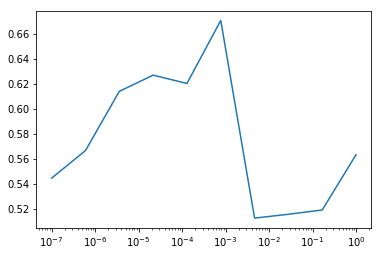

In [34]:
lr_list = np.logspace(-7, 0, 10)

acc_list = []
std_list = []

for lr in lr_list:
    acc, std = cross_validation(lambda: ConvNet1(one_khz=True),
                                x_train_one_khz, y_train_one_khz, epochs=1000, lr=lr)
    acc_list.append(acc)
    std_list.append(std)
    
plt.semilogx(lr_list, acc_list)

In [35]:
save_obj((acc_list, std_list), 'cross_val_lr_one_khz')

In [48]:
acc_list, std_list = load_obj('cross_val_lr_one_khz')
lr_tuned = lr_list[np.argmax(acc_list)]
print('The tuned learning rate is {}.'.format(round(lr_tuned, 6)))

The tuned learning rate is 0.000774.


#### Training the model

In [49]:
acc_list = cross_validation(lambda: ConvNet1(one_khz=True), x_train_one_khz, y_train_one_khz, raw=True,
                            epochs=100, lr=lr_tuned, batch_size=16,
                            standardize=True, noise=False, crop=False)
acc = round(100*np.mean(acc_list), 4)
std = round(100*np.std(acc_list), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 74.0724+/-4.6151%


It seems like the 1kHZ data set doesn't make the accuracy better ; it makes it even worse and we think that it comes from useless additional data points from which the network can't learn anything. Several models were trained on both the 100Hz and the 1kHz data, and it appears that the later doesn't improve the results. Thus, we decided to downsample from it and augment the 100Hz data this way. We do it using the following `downsample` function.

### Basic model with augmented (downsampled) data

In [ ]:
def downsampling(data,target,times,ratio):
    """
    :param times:how many times do you want to augmentate data
    :param ratio:downsampling ratio
    """
    length = data.shape[2]
    for i in range(times):
        Data_subset=Tensor([])
        point = randint(0,length-1)#initial the point
        print(point)
        for j in range(math.floor(length/ratio)):
            if point>=length:
                point -= length
            sample = data[:,:,point].reshape([-1,28,1])
            Data_subset = torch.cat([Data_subset,sample],2)
            point +=ratio
        if i ==0:
            Data = Data_subset
            Target = target
        else:
            Data = torch.cat([Data,Data_subset],0)
            Target = torch.cat([Target,target])
    return Data,Target

### Basic model with downsampled data and noise

Another way to augment the data is to add noise to it. In this section we train the same model with a gaussian noise. Here the data is augmented dynamically through the training process : when a data point is considered, a `GaussianNoise` transformation is applied to it.